In [ ]:
!git push

In [98]:
import xarray as xr
import os
import requests
import numpy as np
import xesmf as xe

In [7]:
def Download_TPCA():
    '''
    Function to download TPCA MODIS and SeaWIFS from nci.org.
    
    Possible to also use DAPPS through xarray and save the files
    rather than using requests.
    '''
    path_sw='/scratch1/pit071/TPCA/seawifs/'
    if not os.path.isdir(path_sw):
        print('Creating directory: ',path_sw)
        os.makedirs(path_sw)
       
    path_mod='/scratch1/pit071/TPCA/modis/'
    if not os.path.isdir(path_mod):
        print('Creating directory: ',path_mod)
        os.makedirs(path_mod)
    
    
    tpca_link=['http://dapds00.nci.org.au/thredds/fileServer/ks32/CLEX_Data/TPCA_reprocessing/v2019_01/']
    sensors=['SeaWiFS/tpca_seawifs_','MODIS-Aqua/tpca_modis_aqua_'] #and then year
    sens=['sw','mod']           
    #Download SeaWiFS files from the above array, spaced by each year.
    
    for i in range(0,2): #To do SeaWiFS and then MODIS
        for yr in np.arange(1997,2020):
            if i==0: #SW
                sensor=tpca_link[0]+sensors[0]+str(yr)+'.nc'
                path=path_sw
            elif i==1: #MODIS
                sensor=tpca_link[0]+sensors[1]+str(yr)+'.nc'
                path=path_mod
        
            #Start the download
            try:
                r = requests.get(sensor)#,timeout=s20)
                fileloc=path+sensors[0].split('/')[1]+str(yr)+'.nc'
                if r.status_code!=404:
                    with open(fileloc, 'wb') as f:
                        f.write(r.content)
                    print('Downloaded: ' + sens[i] + str(yr))
                else:
                    print(i,str(r.status_code))
            except KeyboardInterrupt:
                import sys
                sys.exit()
            except:
                print(str(yr)+ sens[i]+'  Unavailable')
            pass

In [8]:
Download_TPCA()

Creating directory:  /scratch1/pit071/TPCA/seawifs/
Creating directory:  /scratch1/pit071/TPCA/modis/
Downloaded: sw1997
Downloaded: sw1998
Downloaded: sw1999
Downloaded: sw2000
Downloaded: sw2001
Downloaded: sw2002
Downloaded: sw2003
Downloaded: sw2004
Downloaded: sw2005
Downloaded: sw2006
Downloaded: sw2007
Downloaded: sw2008
Downloaded: sw2009
Downloaded: sw2010
0 404
0 404
0 404
0 404
0 404
0 404
0 404
0 404
0 404
1 404
1 404
1 404
1 404
1 404
Downloaded: mod2002
Downloaded: mod2003
Downloaded: mod2004
Downloaded: mod2005
Downloaded: mod2006
Downloaded: mod2007
Downloaded: mod2008
Downloaded: mod2009
Downloaded: mod2010
Downloaded: mod2011
Downloaded: mod2012
Downloaded: mod2013
Downloaded: mod2014
Downloaded: mod2015
Downloaded: mod2016
Downloaded: mod2017
Downloaded: mod2018
Downloaded: mod2019


In [82]:
#Cut PhyDownload_TPCA()
def cut_phyto():
    bgc_month= xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr',consolidated=True)
    bgc_month['xt_ocean']=bgc_month['xt_ocean']+360
    phy=bgc_month.phy.sel(xt_ocean=slice(120,290),yt_ocean=slice(-20,20)).isel(st_ocean=1)
    phy['time']=np.array(phy.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
    phy.to_netcdf('/scratch1/pit071/CAFE60/phy_15m.nc')

In [115]:
#Download_TPCA()
#cut_phyto()

#Load TPCA data
seawifs_tpca=xr.open_mfdataset('/scratch1/pit071/TPCA/seawifs/*nc').rename({'chl_tpca':'seawifs_tpca'})
modis_tpca=xr.open_mfdataset('/scratch1/pit071/TPCA/modis/*nc').rename({'chl_tpca':'modis_tpca'})

#Open Model phyto data
phy=xr.open_dataset('/scratch1/pit071/CAFE60/phy_15m.nc')
phy=phy.rename({'yt_ocean':'lat','xt_ocean':'lon'})

#Make TPCA mean data
tpca=xr.merge([seawifs_tpca,modis_tpca])
mean = tpca_m.to_array(dim='new').mean('new')
tpca_m=tpca_m.assign(tpca=mean)

#Calculate monthly average
tpca_m=tpca.resample({'time':'M'}).mean(dim='time')
tpca_m['time']=tpca_m.time.astype('datetime64[M]')


#Regrid TPCA to Model grid
regridder = xe.Regridder(tpca_m, phy, 'bilinear',reuse_weights=True)
tpca_m_regrid=regridder(tpca_m)

#Fill 0 to NAN
tpca_m_regrid = tpca_m_regrid.where(tpca_m_regrid > 0)
tpca_m_regrid = tpca_m_regrid.bfill('time')
tpca_m_regrid.to_netcdf('/scratch1/pit071/CAFE60/TPCA_month_regrid.nc')

Reuse existing file: bilinear_240x2040_98x170.nc
using dimensions ('lat', 'lon') from data variable seawifs_tpca as the horizontal dimensions for this dataset.


/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/xesmf/frontend.py:477: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [148]:
tpca_m_regrid = xr.open_dataset('/scratch1/pit071/CAFE60/TPCA_month_regrid.nc')
tpca_m_regrid = tpca_m_regrid.where(tpca_m_regrid > 0)
tpca_m_regrid = tpca_m_regrid.bfill('time')

phy['time']=np.array(phy.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
phy=phy.sel(time=tpca_m_regrid.time)

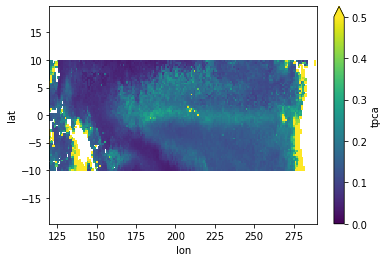

In [190]:
tpca_m_regrid.sel(time=slice(np.datetime64('2010-03-24'),np.datetime64('2010-04-05'))).mean(dim=['time']).tpca.plot(vmin=0,vmax=0.5)

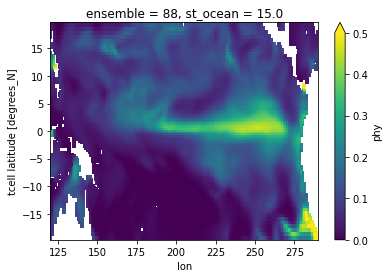

In [228]:
phy.sel(time=slice(np.datetime64('2010-03-01'),np.datetime64('2010-04-01')),ensemble=88).mean(dim=['time']).phy.plot(vmin=0,vmax=0.5)



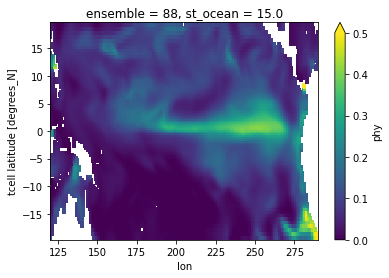

In [229]:
((phy.sel(time=slice(np.datetime64('2010-03-01'),np.datetime64('2010-04-01')),ensemble=88).mean(dim=['time']).phy*893.51)/1000).plot(vmin=0,vmax=0.5)

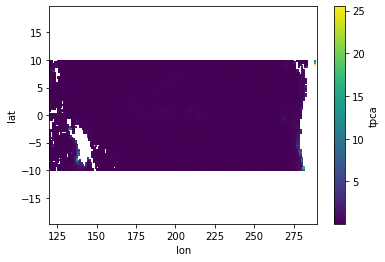

In [219]:
a.plot()

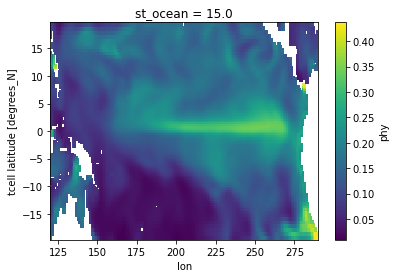

In [226]:
(((b*893.51)/1000)).plot()#(vmin=-0.2,vmax=0.2)

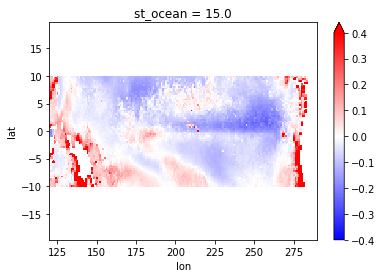

In [214]:
a=tpca_m_regrid.sel(time=slice(np.datetime64('2010-03-24'),np.datetime64('2010-04-05'))).mean(dim=['time']).tpca
b=phy.sel(time=slice(np.datetime64('2010-03-01'),np.datetime64('2010-04-01'))).mean(dim=['time','ensemble']).phy 
b1=phy.sel(time=slice(np.datetime64('2010-03-01'),np.datetime64('2010-04-01')),ensemble=92).mean(dim=['time']).phy 
(a-b).plot(vmin=-0.4,vmax=0.4,cmap='bwr')

In [166]:
(phy-tpca_m_regrid.tpca).phy.mean(dim=['time','ensemble'])

<xarray.DataArray 'phy' (lat: 98, lon: 170)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    st_ocean  float64 15.0
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36

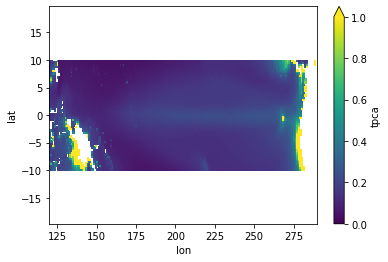

In [146]:
filled.mean(dim='time').tpca.plot(vmin=0,vmax=1)

In [185]:
np.datetime64?

Init signature: np.datetime64(self, /, *args, **kwargs)
Docstring:     
Base class for numpy scalar types.

Class from which most (all?) numpy scalar types are derived.  For
consistency, exposes the same API as `ndarray`, despite many
consequent attributes being either "get-only," or completely irrelevant.
This is the class from which it is strongly suggested users should derive
custom scalar types.
File:           /datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/numpy/__init__.py
Type:           type
Subclasses:     


In [188]:
#start_date = date(2010, 3, 24) #yyyy, mm, dd 3, 24
#end_date = date(2010, 4, 5)
np.datetime64('2010-03-24')
np.datetime64('2010-04-05')

numpy.datetime64('2010-04-05')

In [113]:
tpca_m_regrid.tpca.mean(dim='time').plot()

/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


KeyboardInterrupt: 

In [83]:
def cut_regrid_sst():
    sst_obs=xr.open_dataset('/scratch1/pit071/carbon_data_ch2/sst.mnmean.nc')
    sst_obs=sst_obs.sst.sel(lat=slice(20,-20),lon=slice(120,290),time=slice('1982-01-01','2019-12-01'))
    regridder = xe.Regridder(sst_obs, sst_cafe, 'bilinear',reuse_weights=True)
    sst_obs_regrid=regridder(sst_obs)
    sst_obs_regrid.to_netcdf('/scratch1/pit071/CAFE60/sst.mnmean.regrid.nc')


,Array,Chunk
Bytes,515.06 MB,1.96 MB
Shape,"(263, 240, 2040)","(1, 240, 2040)"
Count,2438 Tasks,263 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,515.06 MB,1.96 MB
Shape,"(263, 240, 2040)","(1, 240, 2040)"
Count,2480 Tasks,263 Chunks
Type,float32,numpy.ndarray


,Array,Chunk
Bytes,4.61 GB,6.40 MB
Shape,"(720, 96, 98, 170)","(1, 96, 98, 170)"
Count,25201 Tasks,720 Chunks
Type,float32,numpy.ndarray


In [76]:
sst['time']=np.array(sst.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
sst=sst.sel(time=slice(np.datetime64('1982-01-01'),np.datetime64('2020-01-01')))
sst=sst.rename({'xt_ocean':'lon','yt_ocean':'lat'})
sst.to_netcdf('/scratch1/pit071/CAFE60/sst.nc')

#Save SOI index.

In [84]:
ls /OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/

atmos_isobaric_daily.zarr/  ocean_daily.zarr/
atmos_isobaric_month.zarr/  ocean_ens_mean_at_analysis.zarr/
ice_month.zarr/             ocean_force_month.zarr/
land_month.zarr/            ocean_grid.nc*
ocean_bgc_daily.zarr/       ocean_month.zarr/
ocean_bgc_month.zarr/       ocean_scalar_month.zarr/


In [81]:
tpca_m

,Array,Chunk
Bytes,515.06 MB,1.96 MB
Shape,"(263, 240, 2040)","(1, 240, 2040)"
Count,2438 Tasks,263 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,515.06 MB,1.96 MB
Shape,"(263, 240, 2040)","(1, 240, 2040)"
Count,2480 Tasks,263 Chunks
Type,float32,numpy.ndarray


In [26]:
#seawifs_tpca['name']='seawifs_tpca'
#modis_tpca['name']='modis_tpca'

tpca=seawifs_tpca
tpca['modis_tpca']=modis_tpca

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

In [23]:
tpca

<xarray.DataArray 'chl_tpca' (time: 4502, lat: 240, lon: 2040)>
dask.array<concatenate, shape=(4502, 240, 2040), dtype=float32, chunksize=(366, 240, 2040), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1997-09-04 1997-09-06 ... 2010-12-11
  * lon         (lon) float32 120.0 120.1 120.2 120.3 ... 289.8 289.9 290.0
  * lat         (lat) float32 9.958 9.875 9.792 9.708 ... -9.792 -9.875 -9.958
    name        <U10 'modis_tpca'
    modis_tpca  (time, lat, lon) float32 dask.array<chunksize=(67, 240, 2040), meta=np.ndarray>
Attributes:
    standard_name:  mass_concentration_of_chlorophyll_a_in_sea_water
    long_name:      mass_concentration_of_chlorophyll_a_in_sea_water
    units:          mg m-3

In [11]:
mean = ds.to_array(dim='new').mean('new')
ds.assign(e=mean)

<xarray.DataArray 'chl_tpca' (time: 4502, lat: 240, lon: 2040)>
dask.array<concatenate, shape=(4502, 240, 2040), dtype=float32, chunksize=(366, 240, 2040), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-09-06 ... 2010-12-11
  * lon      (lon) float32 120.0 120.1 120.2 120.3 ... 289.7 289.8 289.9 290.0
  * lat      (lat) float32 9.958 9.875 9.792 9.708 ... -9.792 -9.875 -9.958
Attributes:
    standard_name:  mass_concentration_of_chlorophyll_a_in_sea_water
    long_name:      mass_concentration_of_chlorophyll_a_in_sea_water
    units:          mg m-3